In [1]:
%matplotlib inline

## Figure 2: Statistics Module

This figure displays the statistics module. First, we'll set up and run a linear model on the MICS dataset. This model contains fixed effects for age and sex, their interaction effect, and a random effect for subject (to account for multiple measurements per subject).


In [2]:
from brainstat.datasets import fetch_mask
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect, MixedEffect
from brainstat.tutorial.utils import fetch_mics_data

thickness, demographics = fetch_mics_data()
mask = fetch_mask("fsaverage5")

term_age = FixedEffect(demographics.AGE_AT_SCAN)
term_sex = FixedEffect(demographics.SEX)
term_subject = MixedEffect(demographics.SUB_ID)
model = term_age + term_sex + term_age * term_sex + term_subject

contrast_age = -demographics.AGE_AT_SCAN
slm = SLM(
    model,
    contrast_age,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm.fit(thickness)


Next, we will plot the t-values and the p-values of clusters, peaks and vertices. To that end we'll first define a plotting function.


In [3]:
from brainspace.plotting import plot_hemispheres
from brainstat.datasets import fetch_mask, fetch_template_surface


def local_plot_hemispheres(
    values, label_text, color_range, template="fsaverage5", cmap="bwr", size=(1400, 200)
):
    surface_left, surface_right = fetch_template_surface(template, join=False)
    return plot_hemispheres(
        surface_left,
        surface_right,
        values,
        color_bar=True,
        color_range=color_range,
        label_text=label_text,
        cmap=cmap,
        size=size,
        embed_nb=True,
        zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1),
        cb__labelTextProperty={"fontSize": 30},
        interactive=False,
    )


Lets plot the t-values


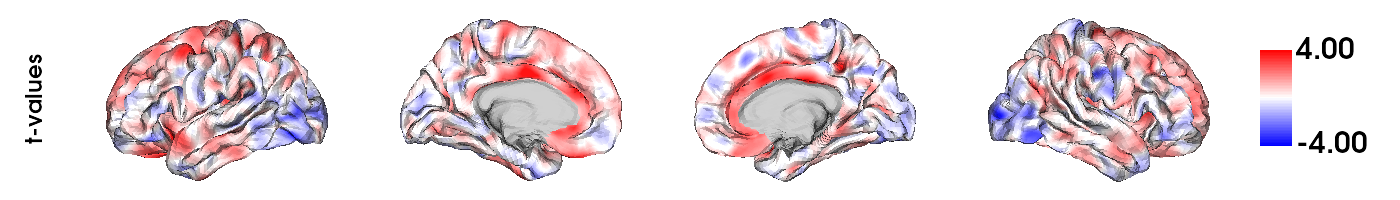

In [4]:
local_plot_hemispheres(slm.t.flatten(), ["t-values"], (-4, 4), cmap="bwr")


Before we plot the p-values lets set those in the midline and above 0.05 to nan as this helps make the plots prettier.


In [5]:
import numpy as np

plot_pvalues = [
    np.copy(slm.P["pval"]["C"]),  # Cluster-wise
    np.copy(slm.P["pval"]["P"]),  # Peak-wise
    np.copy(slm.Q),  # Vertex-wise
]
# Set p-values in the midline and above 0.05 to nan.
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in plot_pvalues]
labels = ["Cluster p-values", "Peak p-values", "Vertex p-values"]


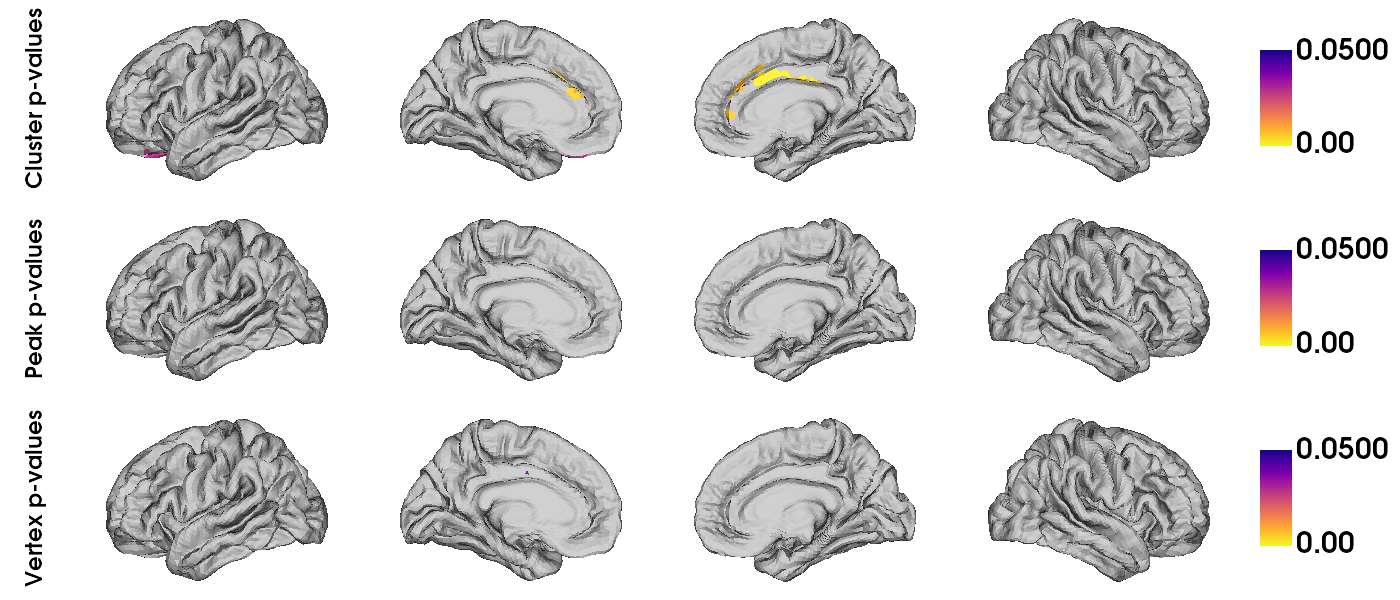

In [6]:
local_plot_hemispheres(
    plot_pvalues, labels, (0, 0.05), cmap="plasma_r", size=(1400, 600)
)


## Figure 3: Meta-Analytic Decoding

Here we decode our t-statistic map using Neurosynth, and plot it in a wordcloud.


2022-09-15 11:22:53,121 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-15 11:22:53,216 - brainstat - INFO - Running correlations with all Neurosynth features.


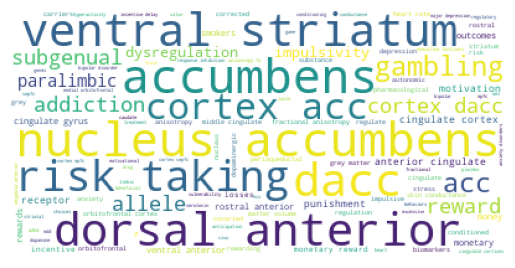

In [7]:
import matplotlib.pyplot as plt

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

meta_analysis = meta_analytic_decoder("fsaverage5", slm.t.flatten())

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()


,nucleus accumbens,accumbens,dorsal anterior,dacc,ventral striatum,risk taking,cortex acc,gambling
0,0.207419,0.207216,0.200371,0.196472,0.194027,0.191846,0.187655,0.187419


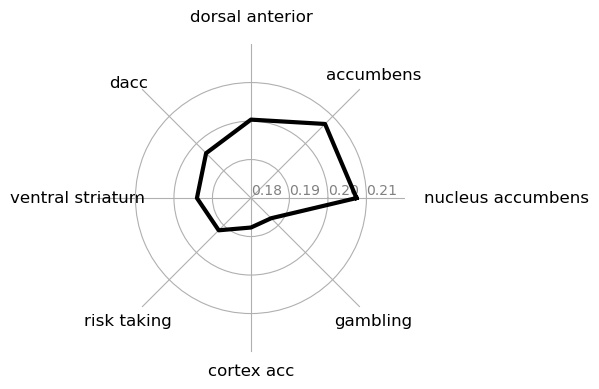

In [8]:
from brainstat.context.meta_analysis import radar_plot

numFeat = 8
data = meta_analysis.to_numpy()[:numFeat]
label = meta_analysis.index[:numFeat]
radar_plot(data, label=label, axis_range=(0.18, 0.22))

## Figure 4: Functional Hierarchy

BrainStat provides contextualization using resting-state functional gradients (Margulies et al., 2016, PNAS), a lower dimensional
manifold of resting-state connectivity.

Lets have a look at the functional gradients and their correlation with the t-statistic map.


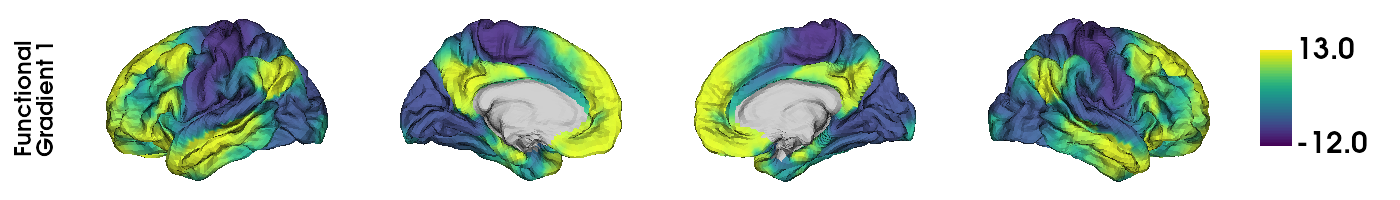

In [9]:
from brainstat.datasets import fetch_gradients

functional_gradients = fetch_gradients("fsaverage5", "margulies2016")
local_plot_hemispheres(
    functional_gradients[:, 0], ["Functional\nGradient 1"], (-12, 13), cmap="viridis"
)


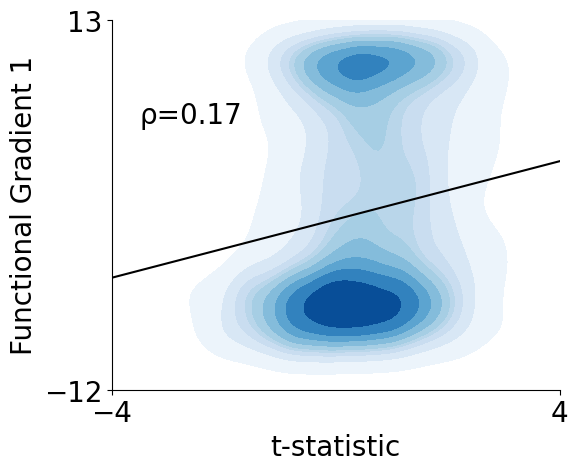

In [10]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"x": slm.t.flatten(), "y": functional_gradients[:, 0]})
df.dropna(inplace=True)

# Create kernel density plot.
_, ax = plt.subplots()
sns.kdeplot(x=df.x, y=df.y, fill=True, ax=ax, cmap="Blues")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xlabel("t-statistic", fontdict={"fontsize": 20})
plt.ylabel("Functional Gradient 1", fontdict={"fontsize": 20})

plt.plot(np.unique(df.x), np.poly1d(np.polyfit(df.x, df.y, 1))(np.unique(df.x)), "k")
plt.text(-3.5, 6, f"ρ={df.x.corr(df.y, method='spearman'):.2f}", fontdict={"size": 20})
plt.gcf().subplots_adjust(left=0.2)

ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-0.13, 0.15)
plt.xticks([-4.0, 4.0], fontsize=20)
plt.yticks([-12, 13], fontsize=20);


## Figure 5: Transcriptomics

First, we'll fetch the genetic expression data in the Allen Human Brain atlas for the schaefer 100 parcellation.


In [11]:
from brainstat.context.genetics import surface_genetic_expression
from brainstat.datasets import fetch_parcellation

# Get Schaefer-100 genetic expression.
schaefer_100_fs5 = fetch_parcellation("fsaverage5", "schaefer", 100)
surfaces = fetch_template_surface("fsaverage5", join=False)
expression = surface_genetic_expression(schaefer_100_fs5, surfaces, space="fsaverage")


2022-09-15 11:24:53,171 - brainstat - INFO - If you use BrainStat's genetics functionality, please cite abagen (https://abagen.readthedocs.io/en/stable/citing.html).


/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed

Next, we can plot the figures shown in the manuscript. 

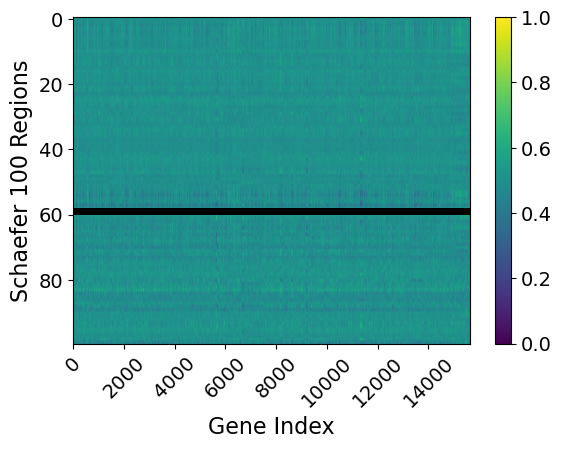

In [12]:
import copy
from matplotlib.cm import get_cmap

colormap = copy.copy(get_cmap())
colormap.set_bad(color="black")

plt.imshow(expression, aspect="auto", cmap=colormap)
plt.colorbar().ax.tick_params(labelsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel("Gene Index", fontdict={"fontsize": 16})
plt.ylabel("Schaefer 100 Regions", fontdict={"fontsize": 16})

plt.gcf().subplots_adjust(bottom=0.2)


Next we'll plot the genetic expression matrix.


Lets also plot the spatial expression pattern of a single gene: WFDC1. Note that we have to transform the parcellated data back to vertex data before we can plot it.


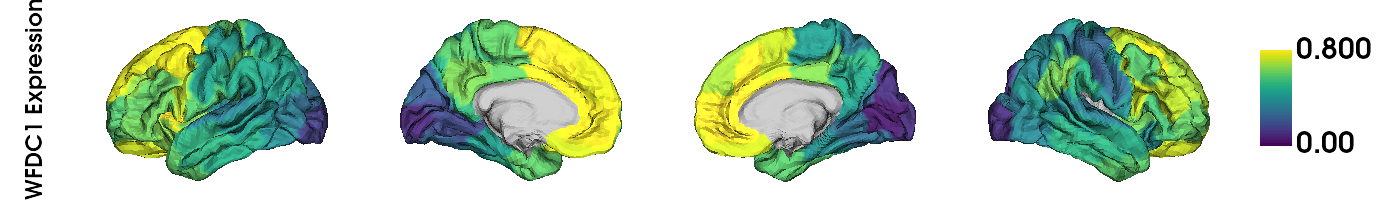

In [13]:
from brainspace.utils.parcellation import map_to_labels

# Set a value for the midline.
values_with_midline = np.concatenate([[np.nan], expression["WFDC1"]])
vertex_wfdc1 = map_to_labels(values_with_midline, schaefer_100_fs5)
local_plot_hemispheres(vertex_wfdc1, ["WFDC1 Expression"], (0, 0.8), cmap="viridis")


Lastly, lets inspect the relationship between our previously derived t-values and this expression map. Recall that our t-values were vertexwise, so we'll have to parcellate these first.


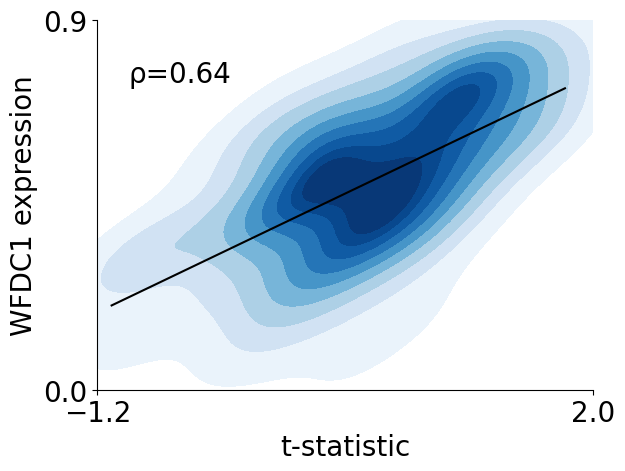

In [14]:
# Plot correlation with WFDC1 gene

from brainspace.utils.parcellation import reduce_by_labels

# Parcellate the t-values and remove rows with no genetic data.
t_stat_schaefer_100 = reduce_by_labels(slm.t.flatten(), schaefer_100_fs5)[1:]
df = pd.DataFrame({"x": t_stat_schaefer_100, "y": expression["WFDC1"]})
df.dropna(inplace=True)

# Create the density plot.
f, ax = plt.subplots()
sns.kdeplot(x=df.x, y=df.y, fill=True, ax=ax, cmap="Blues")

plt.xlabel("t-statistic", fontdict={"fontsize": 20})
plt.ylabel("WFDC1 expression", fontdict={"fontsize": 20})

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.set_xlim(-1.2, 2.0)
ax.set_ylim(0.0, 0.9)

plt.xticks([-1.2, 2])
plt.yticks([0, 0.9])

# Add a best fit line.
plt.plot(np.unique(df.x), np.poly1d(np.polyfit(df.x, df.y, 1))(np.unique(df.x)), "k")
plt.text(-1.0, 0.75, f"ρ={df.x.corr(df.y, method='spearman'):.2f}", fontdict={"size": 20});


## Figure 6: Histological decoding

For histological decoding we use microstructural profile covariance gradients,
as first shown by (Paquola et al, 2019, Plos Biology), computed from the
BigBrain dataset. Lets download the MPC data, compute and plot its
gradients, and correlate the first gradient with our t-statistic map.


/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/brainstat/context/histology.py:105: RuntimeWarning: divide by zero encountered in divide
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))
/Users/saratheriver/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/brainstat/context/histology.py:105: RuntimeWarning: invalid value encountered in log
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))


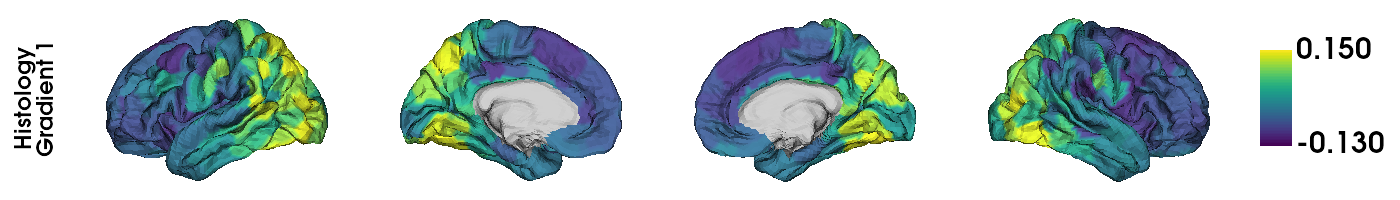

In [15]:
from brainstat.context.histology import (
    compute_histology_gradients,
    compute_mpc,
    read_histology_profile,
)

# Run the analysis
schaefer_400 = fetch_parcellation("fsaverage5", "schaefer", 400)
histology_profiles = read_histology_profile(template="fsaverage5")
mpc = compute_mpc(histology_profiles, labels=schaefer_400)
gradient_map = compute_histology_gradients(mpc, random_state=0)

# Bring parcellated data to vertex data.
vertexwise_gradient = map_to_labels(
    gradient_map.gradients_[:, 0],
    schaefer_400,
    mask=schaefer_400 != 0,
    fill=np.nan,
)

local_plot_hemispheres(vertexwise_gradient, ["Histology\nGradient 1"], (-0.13, 0.15), cmap="viridis")

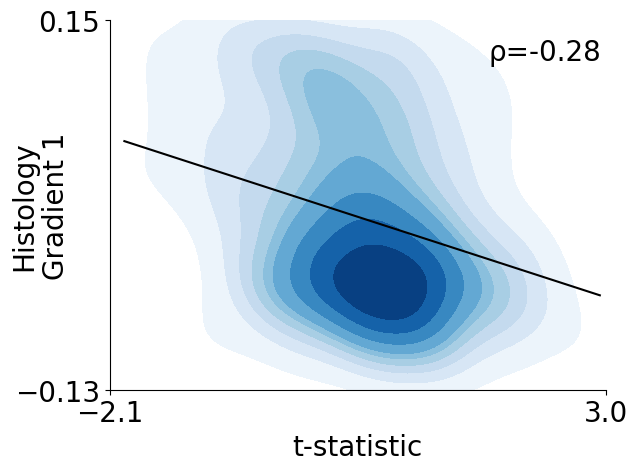

In [16]:
# Parcellate the t-values
t_stat_schaefer_400 = reduce_by_labels(slm.t.flatten(), schaefer_400)[1:]
df = pd.DataFrame({"x": t_stat_schaefer_400, "y": gradient_map.gradients_[:, 0]})

# Create the density plot.
f, ax = plt.subplots()
sns.kdeplot(x=df.x, y=df.y, fill=True, ax=ax, cmap="Blues")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("t-statistic", fontdict={"fontsize": 20})
plt.ylabel("Histology\nGradient 1", fontdict={"fontsize": 20}, labelpad=-40)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim(-2.1, 3)
ax.set_ylim(-0.13, 0.15)

plt.xticks([-2.1, 3])
plt.yticks([-0.13, 0.15])

# Add a best fit line.
plt.plot(np.unique(df.x), np.poly1d(np.polyfit(df.x, df.y, 1))(np.unique(df.x)), "k")
plt.text(1.8, 0.12, f"ρ={df.x.corr(df.y, method='spearman'):.2f}", fontdict={"size": 20});
